In [1]:
import torch
import pickle
import numpy as np

from torch import nn
from glob import glob
from tqdm import trange
from torch.optim import Adam
from collections import defaultdict
from matplotlib.pyplot import imshow

from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
def getData(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')

    # https://stackoverflow.com/questions/63705615/unable-to-reshape-numpy-array-to-rgb-image
    # i'm dumb asf
    dict[b'data'] = dict[b'data'].reshape(10000, 3, 1024)
    # dict[b'data'] = np.swapaxes(dict[b'data'], 1, 2)
    # dict[b'data'] = dict[b'data'].reshape(10000, 32, 32, 3)
    dict[b'data'] = dict[b'data'].reshape(10000, 3, 32, 32)
    return dict[b'data'], dict[b'labels']

In [3]:
train = defaultdict(list)
test = defaultdict(list)

# load train dataset
for file in glob('/mnt/Seagate/Code/ml-playground/cifar10/data/*[0-9]'):
    data, label = getData(file)
    if len(train['data']) == 0:
        train['data'] = data
        train['label'] = label
    else:
        train['data'] = np.concatenate((train['data'], data))
        train['label'] = np.concatenate((train['label'], label))

# laod test dataset
test['data'], test['label'] = getData(
    "/mnt/Seagate/Code/ml-playground/cifar10/data/test_batch")

# load class names
with open('/mnt/Seagate/Code/ml-playground/cifar10/data/batches.meta', 'rb') as f:
    classes = np.array(pickle.load(f)['label_names'])

['cat' 'bird' 'ship' 'frog' 'automobile' 'cat' 'airplane' 'airplane'
 'automobile' 'bird' 'dog' 'bird' 'deer' 'dog' 'horse' 'automobile'
 'automobile' 'truck' 'truck' 'frog' 'horse' 'frog' 'ship' 'dog' 'frog'
 'automobile' 'ship' 'horse' 'frog' 'truck' 'cat' 'dog' 'cat' 'automobile'
 'bird' 'truck' 'dog' 'ship' 'bird' 'dog' 'airplane' 'deer' 'truck'
 'horse' 'dog' 'airplane' 'cat' 'airplane' 'ship' 'airplane' 'bird'
 'horse' 'bird' 'airplane' 'ship' 'automobile' 'truck' 'truck' 'deer'
 'truck' 'ship' 'dog' 'automobile' 'dog']


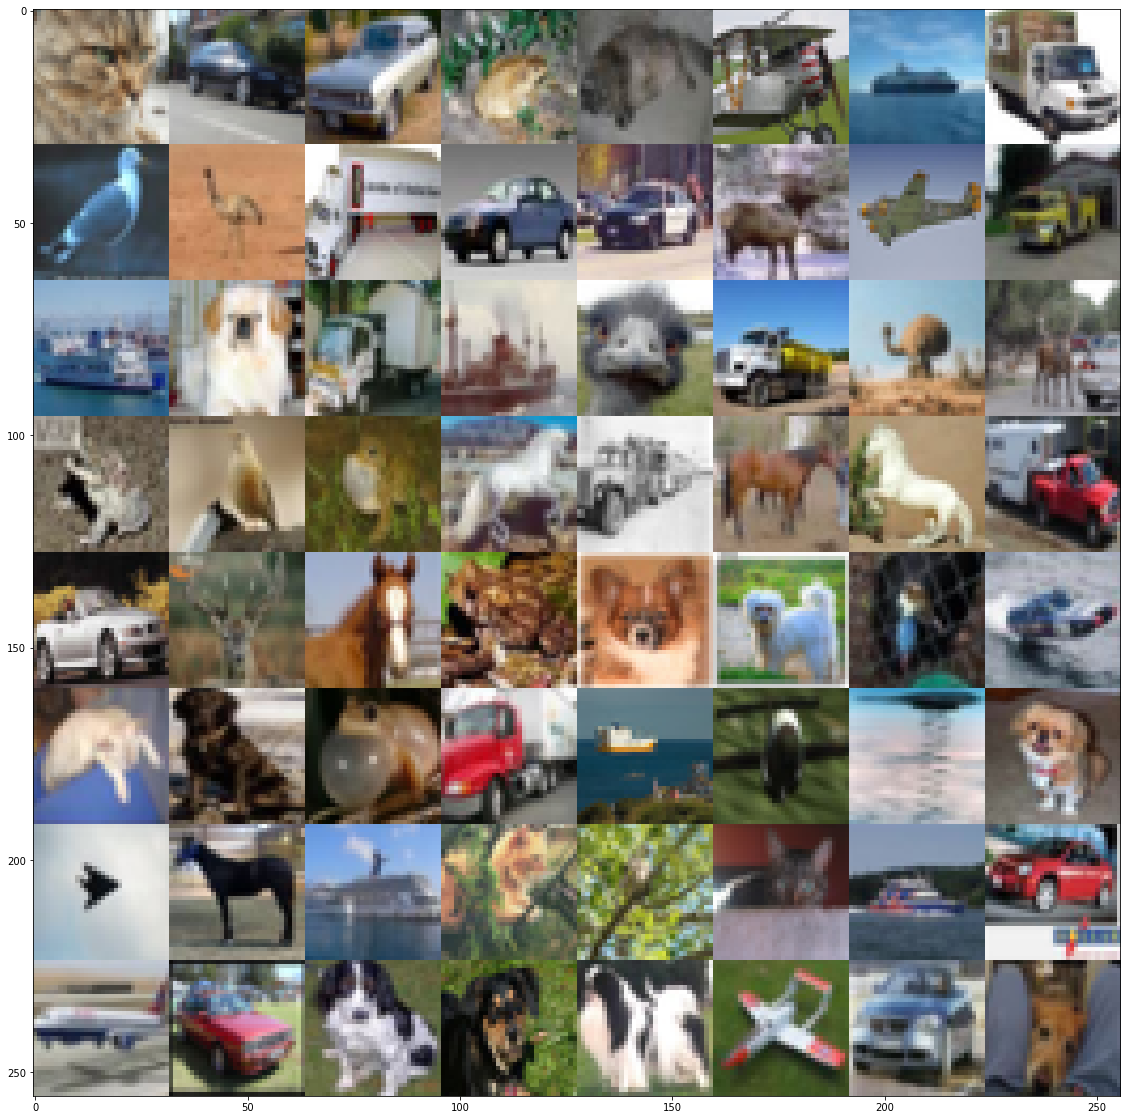

In [4]:
# kinda proud of this xd
size = 64
sqrtSize = 8
plt.figure(figsize=(20, 20))
sampIdx = np.random.randint(low=0, high=50000, size=size)

samp = train['data'][sampIdx]
samp = np.swapaxes(samp, 1, 2)
samp = np.swapaxes(samp, 2, 3)
samp = samp.reshape(sqrtSize, 32*sqrtSize, 32, 3)
samp = np.concatenate(samp, 1)
imshow(samp)
print(classes[np.array(train['label'][sampIdx]).astype(np.int0)])

In [5]:
class JediNet(nn.Module):
    """
    assuming that the shapes of the image and kernel are square
    (INPUT_SIZE - KERNEL_SIZE + (2 * PADDING_SIZE))/STRIDE + 1
    """

    def __init__(self, batch_size=128):
        super(JediNet, self).__init__()
        self.batch_size = batch_size
        self.demo = False
        
        self.l1 = nn.Sequential(nn.Conv2d(3, 32, 3, stride=1, padding=1),  # 32, 32, 32
                                nn.ReLU(),
                                nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 32, 32, 64
                                nn.ReLU(),
                                nn.MaxPool2d(2, stride=2))  # 16, 16, 64

        self.l2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 16, 16, 128
                                nn.ReLU(),
                                nn.Conv2d(128, 64, 3, stride=1, padding=1),  # 16, 16, 64
                                nn.ReLU(),
                                nn.MaxPool2d(2, stride=2))  # 8, 8, 64

        self.l3 = nn.Sequential(nn.Conv2d(64, 32, 3, stride=1, padding=1),  # 8, 8, 32
                                nn.ReLU(),
                                nn.Conv2d(32, 8, 3, stride=1, padding=1),  # 8, 8, 8
                                nn.ReLU())

        self.fc1 = nn.Linear(8 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        # use xavier_uniform to init weights
        for layer in self.l1.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
        for layer in self.l2.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
        for layer in self.l3.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                
        size = self.fc1.weight.size()
        size = np.sqrt(size[0] * size[1])
        nn.init.uniform_(self.fc1.weight, -1./size, 1./size)
        size = self.fc2.weight.size()
        size = np.sqrt(size[0] * size[1])
        nn.init.uniform_(self.fc2.weight, -1./size, 1./size)
    
    def visualize(self, val):
        self.demo = val
        
    def forword_normal(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = out.reshape(batch_size, -1)
        out = F.relu(self.fc1(out))
        out = F.log_softmax(self.fc2(out), dim=1)
        return out
    
    def forword_visualize(self, x):
        relu = nn.ReLU()
        pool = nn.MaxPool2d(2, 2)
        l1 = self.l1(x)
        out = relu(l1)
        out = pool(out)
        # out = l1
        
        l2 = self.l2(out)
        out = relu(l2)
        out = pool(out)
        # out = l2
        
        out = self.l3(out)
        out = out.reshape(1, -1)
        out = F.relu(self.fc1(out))
        out = F.log_softmax(self.fc2(out), dim=1)
        return l1, l2, out
        
    def forward(self, x):
        if self.demo == True:
            return self.forword_visualize(x)
        else:
            return self.forword_normal(x)


In [6]:
# init model
MODEL_PATH = '/mnt/Seagate/Code/ml-playground/cifar10/models/'
load_model = True
batch_size = 128
epochs = 5
losses = []
accuracies = []

jediNet = JediNet(batch_size)
if load_model:
    jediNet.load_state_dict(torch.load(MODEL_PATH + 'cifar_72.pth'))
optim = Adam(jediNet.parameters(), lr=1e-3)

In [6]:
# train model
for i in trange(epochs):
    for _ in range(1000):
        optim.zero_grad()
        samp = np.random.randint(0, 50000, size=batch_size)
        x, y = torch.Tensor(train['data'][samp]), torch.Tensor(
            train['label'][samp]).long()
        y_pred = jediNet(x)
        loss = F.nll_loss(y_pred, y)
        loss.backward()
        optim.step()
        accuracy = (torch.argmax(y_pred, axis=1) == y).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy)

100%|██████████| 5/5 [33:03<00:00, 396.73s/it]


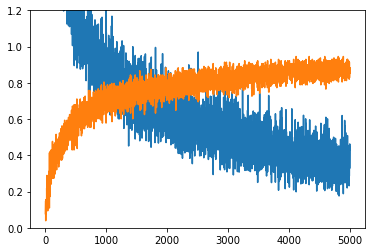

In [7]:
plt.ylim(0, 1.2)
plt.plot(losses)
plt.plot(accuracies)

In [7]:
total = 0
accuracy = 0
jediNet.visualize(False)

with torch.no_grad():
    for i in range(len(test['label'])//batch_size):
        low = i*batch_size
        x = torch.Tensor(test['data'][low: low + batch_size]).float()
        y = torch.Tensor(test['label'][low: low + batch_size]).long()
        y_pred = jediNet(x)
        accuracy += int(torch.sum(y == torch.argmax(y_pred, axis=1)))
        total += batch_size

print(f"Accuracy: {accuracy/total * 100}%")

Accuracy: 72.12540064102564%


In [7]:
# remove maxpool and relu layers form the model to visualize how the model learns
jediNet.l1 = torch.nn.Sequential(*(list(jediNet.l1.children())[:-2]))
jediNet.l2 = torch.nn.Sequential(*(list(jediNet.l2.children())[:-2]))

y:  airplane
y_pred:  airplane


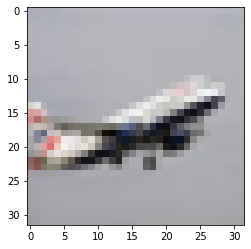

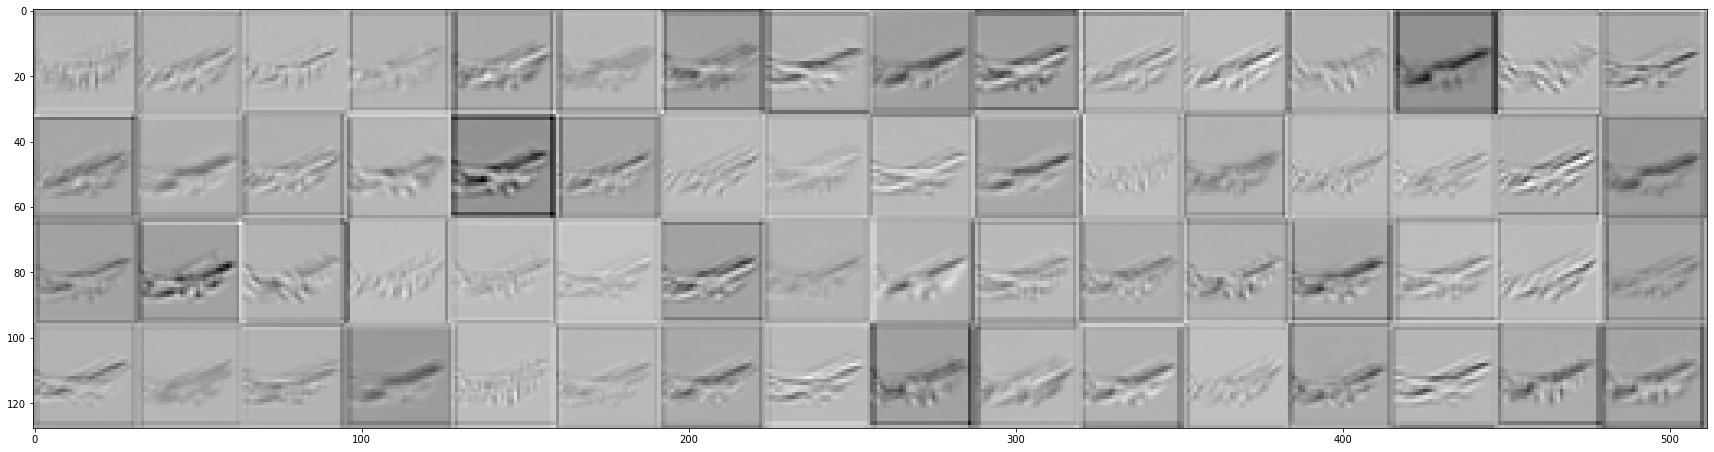

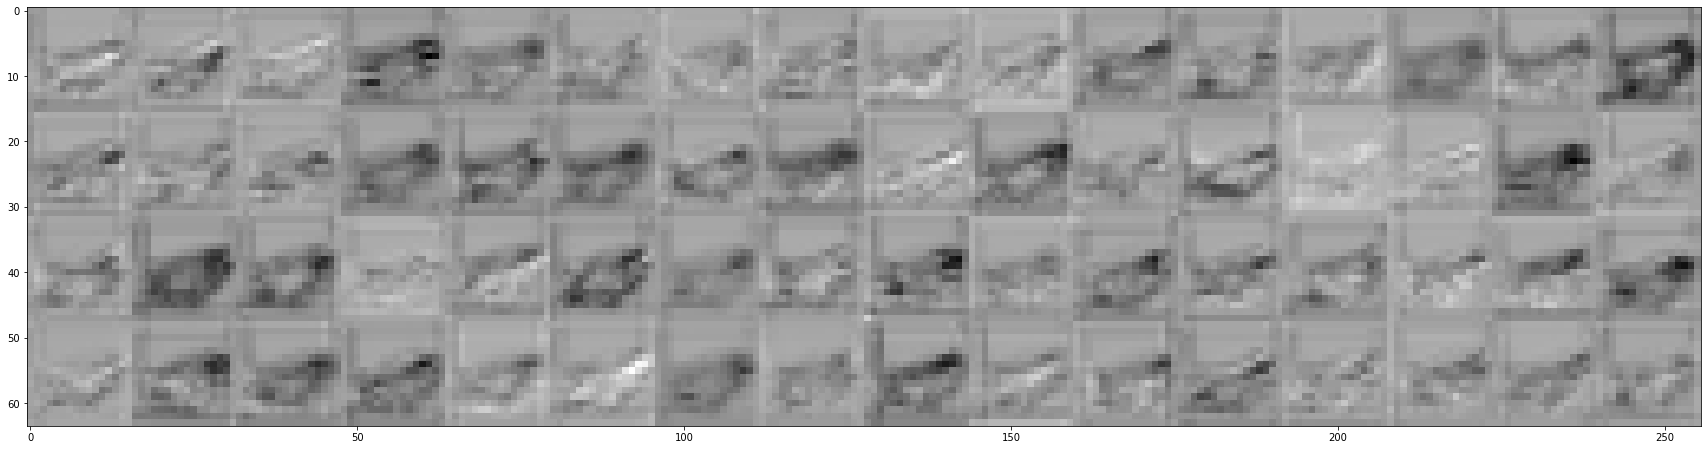

In [13]:
jediNet.eval()
jediNet.visualize(True)
samp = np.random.randint(0, 50000)

x = train['data'][samp]
imshow(x.swapaxes(0, 1).swapaxes(1, 2))
x = torch.Tensor(x[np.newaxis, :])
l1, l2, out = jediNet(x)
print('y: ', classes[train['label'][samp]])
print('y_pred: ', classes[torch.argmax(out)])

for layer in [l1, l2]:
    layer = layer.squeeze()
    filters, w, h = layer.size()
    x, y, dx, dy = 4, filters//4, 0, 0
    image = np.zeros((x*w, h*y))
    
    for i in range(filters):
        dy = i % y
        array = layer[i].detach().numpy()
        image[dx*w:(dx*w)+w, h*dy:(dy*h)+h] = array
        if (dy == 15):
            dx += 1
        
    plt.figure(figsize=(30,30))
    imshow(image, cmap='gray')

In [9]:
if not load_model:
    torch.save(jediNet.state_dict(), MODEL_PATH + 'cifar_72.pth')